# IMPORT

In [18]:
import os, json, glob
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import cv2
import pickle

# LOAD DATASETS

In [8]:
DATA_DIR = r"D:\05_Personal\Asah by Dicoding\capstone-project\data\eye-datasets"
print("DATA_DIR =", DATA_DIR)

# cek folder benar atau tidak
print("Folder exists:", os.path.exists(DATA_DIR))

# cek jumlah file
print("JSON count:", len(glob.glob(os.path.join(DATA_DIR, "*.json"))))
print("JPG count :", len(glob.glob(os.path.join(DATA_DIR, "*.jpg"))))


IMG_SIZE = 128
X_images = []
y_labels = []

json_files = sorted(glob.glob(os.path.join(DATA_DIR, "*.json")))
print("Total JSON found:", len(json_files))


def json_to_jpg(json_path):
    """Cari pasangan JPG berdasarkan nama file JSON."""
    base = json_path[:-5]
    for ext in [".jpg", ".png", ".jpeg", ".JPG", ".JPEG"]:
        p = base + ext
        if os.path.exists(p):
            return p
    return None


def parse_look_vec(vec_str):
    vec_str = vec_str.replace("(", "").replace(")", "")
    x, y, z, w = vec_str.split(",")
    return float(x), float(y)

def gaze_to_label(gx, gy, thr=0.12):
    if gx < -thr: return "left"
    if gx >  thr: return "right"
    if gy < -thr: return "up"
    if gy >  thr: return "down"
    return "center"


for jf in tqdm(json_files):
    img_path = json_to_jpg(jf)

    if img_path is None:
        print("[WARNING] Image missing for:", jf)
        continue

    img = cv2.imread(img_path)
    if img is None:
        print("[ERROR] Cannot read image:", img_path)
        continue

    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))

    with open(jf, "r") as f:
        ann = json.load(f)

    gx, gy = parse_look_vec(ann["eye_details"]["look_vec"])
    label = gaze_to_label(gx, gy)

    X_images.append(img)
    y_labels.append(label)

X_images = np.array(X_images)
y_labels = np.array(y_labels)

print("Loaded images:", len(X_images))
print("Loaded labels:", len(y_labels))


DATA_DIR = D:\05_Personal\Asah by Dicoding\capstone-project\data\eye-datasets
Folder exists: True
JSON count: 3149
JPG count : 3149
Total JSON found: 3149


100%|██████████| 3149/3149 [00:08<00:00, 376.14it/s]


Loaded images: 3149
Loaded labels: 3149


# LABEL

In [9]:
def parse_look_vec(vec_str):
    vec_str = vec_str.replace("(", "").replace(")", "")
    x, y, _, _ = vec_str.split(",")
    return float(x), float(y)

def gaze_to_label(gx, gy, thr=0.12):
    if gx < -thr: return "left"
    if gx >  thr: return "right"
    if gy < -thr: return "up"
    if gy >  thr: return "down"
    return "center"


# ENCODE + DATA SPLIT

In [10]:
enc = LabelEncoder()
y_enc = enc.fit_transform(y_labels)

X_train, X_test, y_train, y_test = train_test_split(
    X_images, y_enc, test_size=0.2, random_state=42, stratify=y_enc
)

# BUILD MODEL

In [11]:

IMG_SIZE = 128

base = tf.keras.applications.MobileNetV2(
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    include_top=False,
    weights="imagenet",
    alpha=1.0 
)

# Unfreeze semua layer (real fine-tuning)
base.trainable = True

# AUGMENTASI + FINE TUNNING

In [12]:
data_aug = tf.keras.Sequential([
    layers.RandomBrightness(0.2),
    layers.RandomContrast(0.2),
    layers.RandomRotation(0.08),
    layers.RandomZoom(0.10),
    layers.RandomFlip("horizontal"),
])

inputs = layers.Input((IMG_SIZE, IMG_SIZE, 3))

x = data_aug(inputs)
x = tf.keras.applications.mobilenet_v2.preprocess_input(x)

x = base(x, training=True)

x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(128, activation="relu")(x)
x = layers.Dropout(0.2)(x)

outputs = layers.Dense(5, activation="softmax")(x)

model = models.Model(inputs, outputs)

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide_1 (TrueDivide)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract_1 (Subtract)           │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_128            │ (None, 4, 4, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,597 (9.24 MB)

 Trainable params: 2,388,485 (9.11 MB)

 Non-trainable params: 34,112 (133.25 KB)

# TRAINNING

In [13]:
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=25,
    batch_size=32,
    shuffle=True
)

Epoch 1/25
63/63 ━━━━━━━━━━━━━━━━━━━━ 41s 368ms/step - accuracy: 0.6238 - loss: 1.1081 - val_accuracy: 0.6508 - val_loss: 1.1497
Epoch 2/25
63/63 ━━━━━━━━━━━━━━━━━━━━ 22s 343ms/step - accuracy: 0.6794 - loss: 0.9148 - val_accuracy: 0.6369 - val_loss: 1.0829
Epoch 3/25
63/63 ━━━━━━━━━━━━━━━━━━━━ 22s 346ms/step - accuracy: 0.6958 - loss: 0.8254 - val_accuracy: 0.6706 - val_loss: 0.9248
Epoch 4/25
63/63 ━━━━━━━━━━━━━━━━━━━━ 22s 347ms/step - accuracy: 0.7097 - loss: 0.7576 - val_accuracy: 0.6429 - val_loss: 0.9879
Epoch 5/25
63/63 ━━━━━━━━━━━━━━━━━━━━ 22s 347ms/step - accuracy: 0.7340 - loss: 0.7002 - val_accuracy: 0.5992 - val_loss: 1.1181
Epoch 6/25
63/63 ━━━━━━━━━━━━━━━━━━━━ 22s 351ms/step - accuracy: 0.7682 - loss: 0.6284 - val_accuracy: 0.6409 - val_loss: 0.9636
Epoch 7/25
63/63 ━━━━━━━━━━━━━━━━━━━━ 22s 350ms/step - accuracy: 0.7906 - loss: 0.5612 - val_accuracy: 0.6726 - val_loss: 0.8622
Epoch 8/25
63/63 ━━━━━━━━━━━━━━━━━━━━ 22s 348ms/step - accuracy: 0.8169 - loss: 0.4839 - val_accu

# PLOT AKURASI

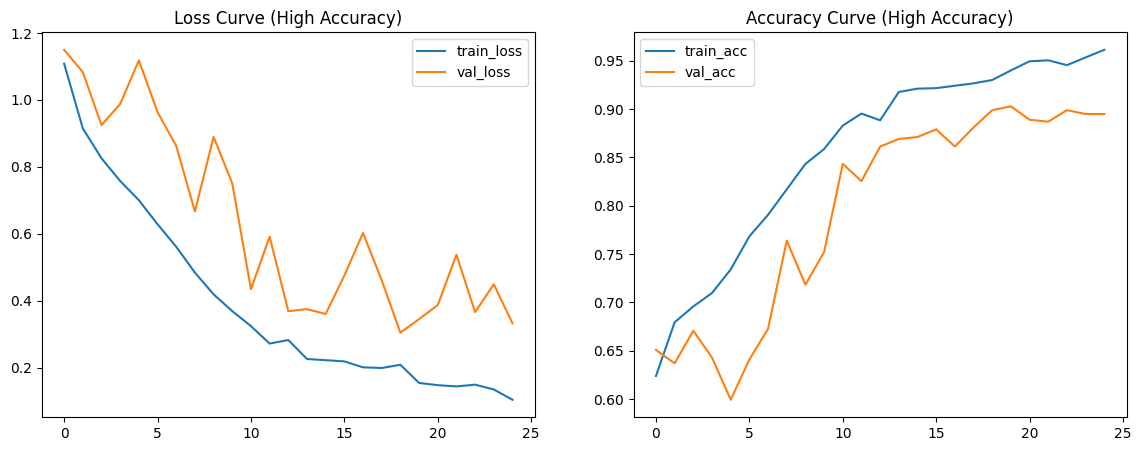

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14,5))

plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.title("Loss Curve (High Accuracy)")

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.legend()
plt.title("Accuracy Curve (High Accuracy)")

plt.show()

# SAVE MODEL

In [21]:
MODEL_PATH = "gaze_high_accuracy.keras"

model.save(
    MODEL_PATH,
    include_optimizer=False
)

print("Model saved to:", MODEL_PATH)

Model saved to: gaze_high_accuracy.keras


In [20]:
with open("label_encoder.pkl", "wb") as f:
    pickle.dump(enc, f)

print("Label encoder saved.")

Label encoder saved.
